In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("Mental Health Dataset.csv")
data.head()

,posts,predicted,intensity
0,I know as parent of child with down syndrome t...,negative,-1
1,but in my heart I know this is the future prom...,neutral,0
2,I have mylefibrosis which turn to leukemia the...,negative,-1
3,from one of my health group subject wayne dyer...,neutral,0
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0


In [3]:
# Data size
print(f'{data.shape[0]} rows')
print(f'{data.shape[1]} columns')

10392 rows
3 columns


In [4]:
print("==" * 30)
print(" " * 19, "Dataset Information")
print("==" * 30)
print(data.info())

                    Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10392 entries, 0 to 10391
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   posts      10391 non-null  object
 1   predicted  10392 non-null  object
 2   intensity  10392 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ KB
None


In [5]:
print(f"{data.duplicated().sum()}")


0


In [6]:
data.isnull().sum()


posts        1
predicted    0
intensity    0
dtype: int64

In [7]:
data = data.dropna()

data.isnull().sum()

posts        0
predicted    0
intensity    0
dtype: int64

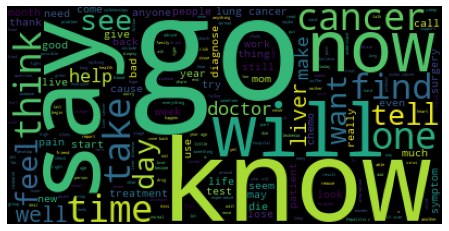

In [8]:
# WordCloud
all_text = " ".join(data['posts'])

wc = WordCloud(stopwords = STOPWORDS).generate(all_text)

plt.figure(figsize = (9,4))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [9]:
seq_len = [None] * len(data)

for i,post in enumerate(data['posts']):
    
    seq_len[i] = len(post.split())

Max seq: 5413


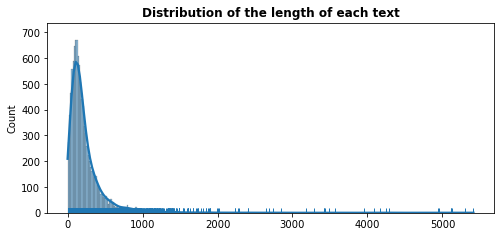

In [10]:
print("==" * 15)
print(f'Max seq: {max(seq_len)}')
print("==" * 15)
plt.figure(figsize = (8,3.5))
sns.histplot(seq_len, kde = True, line_kws = {'linewidth':2.3})
sns.rugplot(seq_len)
plt.title("Distribution of the length of each text", fontsize = 12, fontweight = "bold")
plt.show()


In [11]:
# Define language model
nlp = spacy.load("en_core_web_sm")


In [12]:
# Text preprocessing
def preprocess(txt:str):
    
    doc = nlp(txt)
    
    tokens_filtrered = []
    
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
            
        tokens_filtrered.append(token.lemma_)
        
    return " ".join(tokens_filtrered)

In [13]:
# We apply preprocessing.
data['posts_prep'] = data['posts'].apply(preprocess)

In [14]:
# We select the features that interest us.
data_new = data[['posts_prep','intensity']]
data_new.head()

,posts_prep,intensity
0,know parent child syndrome hear child high ris...,-1
1,heart know future promise article regardless h...,0
2,mylefibrosis turn leukemia want stem cell tran...,-1
3,health group subject wayne dyer leukemia case ...,0
4,gmos link leukemia http nsnbc 2013 07 17 gmo l...,0


<AxesSubplot:xlabel='intensity', ylabel='count'>

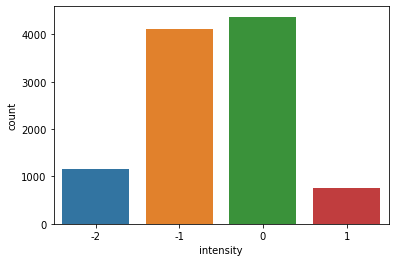

In [15]:
sns.countplot(data_new['intensity'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_new['posts_prep'], 
                                                    data_new['intensity'], 
                                                    test_size = 0.2, 
                                                    random_state = 42)


In [17]:
# Text vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_tfidf=X_train_tfidf.toarray()
X_test_tfidf=X_test_tfidf.toarray()

In [18]:
from imblearn.over_sampling import SMOTE


# SMOTE

In [19]:
# Apply SMOTE to the TF-IDF feature space
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test_tfidf, y_test)


In [63]:
X_train_resampled.shape

(13940, 34335)

In [59]:
X_train_resampled[0].shape


(34335,)

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
import xgboost as xgb 

In [24]:
from sklearn.tree import DecisionTreeClassifier

# RandomForestClassifier

In [25]:
rfc=RandomForestClassifier()


In [26]:
rfc.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [27]:
# Predictions
y_pred_train = rfc.predict(X_train_resampled)
y_pred_test = rfc.predict(X_test_resampled)

In [28]:
accuracy_score(y_train_resampled,y_pred_train)

0.999713055954089

In [29]:
accuracy_score(y_test_resampled,y_pred_test)

0.6805399325084365

<AxesSubplot:>

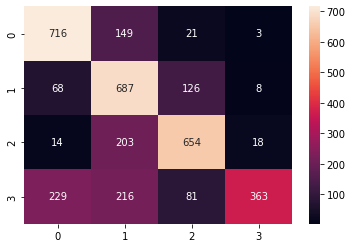

In [30]:
cm=confusion_matrix(y_test_resampled,y_pred_test)
sns.heatmap(cm,fmt='d',annot=True)
# Public F1-Score = 0.727

In [31]:
print(classification_report(y_test_resampled,y_pred_test))

              precision    recall  f1-score   support

          -2       0.70      0.81      0.75       889
          -1       0.55      0.77      0.64       889
           0       0.74      0.74      0.74       889
           1       0.93      0.41      0.57       889

    accuracy                           0.68      3556
   macro avg       0.73      0.68      0.67      3556
weighted avg       0.73      0.68      0.67      3556



# LogisticRegression

In [32]:
lr=LogisticRegression()


In [33]:
lr.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [34]:
# Predictions
y_pred_train = lr.predict(X_train_resampled)
y_pred_test = lr.predict(X_test_resampled)

In [35]:
accuracy_score(y_train_resampled,y_pred_train)

0.9078909612625538

In [36]:
accuracy_score(y_test_resampled,y_pred_test)

0.7466254218222722

<AxesSubplot:>

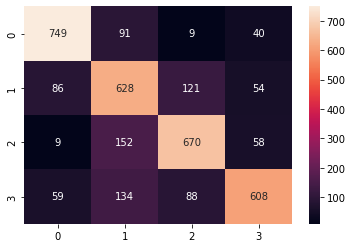

In [37]:
cm=confusion_matrix(y_test_resampled,y_pred_test)
sns.heatmap(cm,fmt='d',annot=True)
# Public F1-Score = 0.727

In [38]:
print(classification_report(y_test_resampled,y_pred_test))

              precision    recall  f1-score   support

          -2       0.83      0.84      0.84       889
          -1       0.62      0.71      0.66       889
           0       0.75      0.75      0.75       889
           1       0.80      0.68      0.74       889

    accuracy                           0.75      3556
   macro avg       0.75      0.75      0.75      3556
weighted avg       0.75      0.75      0.75      3556



# KNeighborsClassifier

In [39]:
knc=KNeighborsClassifier()


In [40]:
knc.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier()

In [41]:
# Predictions
y_pred_train = knc.predict(X_train_resampled)
y_pred_test = knc.predict(X_test_resampled)

In [42]:
accuracy_score(y_train_resampled,y_pred_train)

0.5153515064562411

In [43]:
accuracy_score(y_test_resampled,y_pred_test)

0.2941507311586052

<AxesSubplot:>

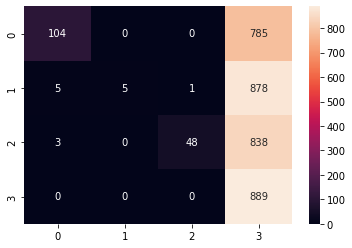

In [44]:
cm=confusion_matrix(y_test_resampled,y_pred_test)
sns.heatmap(cm,fmt='d',annot=True)
# Public F1-Score = 0.727

In [45]:
print(classification_report(y_test_resampled,y_pred_test))

              precision    recall  f1-score   support

          -2       0.93      0.12      0.21       889
          -1       1.00      0.01      0.01       889
           0       0.98      0.05      0.10       889
           1       0.26      1.00      0.42       889

    accuracy                           0.29      3556
   macro avg       0.79      0.29      0.18      3556
weighted avg       0.79      0.29      0.18      3556



# DecisionTreeClassifier

In [46]:
dtc=DecisionTreeClassifier()


In [47]:
dtc.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier()

In [48]:
# Predictions
y_pred_train = dtc.predict(X_train_resampled)
y_pred_test = dtc.predict(X_test_resampled)

In [49]:
accuracy_score(y_train_resampled,y_pred_train)

0.999713055954089

In [50]:
accuracy_score(y_test_resampled,y_pred_test)

0.5987064116985377

<AxesSubplot:>

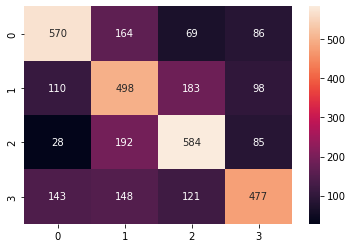

In [51]:
cm=confusion_matrix(y_test_resampled,y_pred_test)
sns.heatmap(cm,fmt='d',annot=True)
# Public F1-Score = 0.727

In [52]:
print(classification_report(y_test_resampled,y_pred_test))

              precision    recall  f1-score   support

          -2       0.67      0.64      0.66       889
          -1       0.50      0.56      0.53       889
           0       0.61      0.66      0.63       889
           1       0.64      0.54      0.58       889

    accuracy                           0.60      3556
   macro avg       0.60      0.60      0.60      3556
weighted avg       0.60      0.60      0.60      3556

